# First quimb
Created 21/05/2024

Objectives:
* Implement quimb optimization on a simple example.
* Convert tenpy mps to quimb object.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [4]:
import numpy as np

In [5]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [6]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [7]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [8]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [9]:
psi = loaded_data_non_triv_proj_rep[0.45]

# Convert to quimb MPS

In [10]:
from collections import Counter

In [11]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [12]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [13]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

In [14]:
"""
q1.retag_sites(
    'TO_CONTRACT',
    [i for i in range(psi.L) if (i<60) or (i>=140)],
    inplace=True
)
"""
None

In [15]:
"""
q2 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr',
        site_ind_id='b{}'
    )
)
"""

q2 = q1.copy()

In [14]:
np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [16]:
"""
sym_ops = [
    qtn.Tensor(np_10, inds=('k{i}', 'b{i}'), tags='sym_op')
    for i in range(60, 141, 2)
]
"""

"\nsym_ops = [\n    qtn.Tensor(np_10, inds=('k{i}', 'b{i}'), tags='sym_op')\n    for i in range(60, 141, 2)\n]\n"

In [27]:
for i in range(60, 141, 2):

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

In [28]:
q2.H @ q1

(4.120254404779311e-18-4.767640108825414e-31j)

In [29]:
tn = q2.H & q1

In [30]:
tn

TensorNetwork1D(tensors=441, indices=639, L=200, max_bond=8)

In [33]:
num_sites = 6
num_symmetry_sites = 80
num_psi_sites = psi.L
left_most_symmetry_site=60

sites_to_contract = (
    list(range(left_most_symmetry_site-num_sites))
    + list(range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites))
    + list(range(left_most_symmetry_site+num_symmetry_sites+num_sites, num_psi_sites))
)

tags_to_contract = [f'I{i}' for i in sites_to_contract]

In [34]:
tnc = tn ^ tags_to_contract

In [35]:
tnc

TensorNetwork1D(tensors=26, indices=41, L=200, max_bond=8)

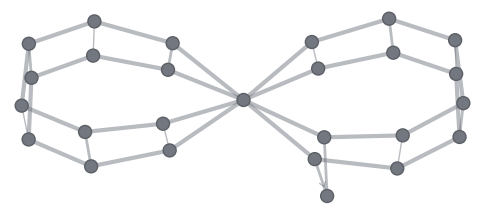

In [39]:
tnc.draw()

Hmm... try another way.

In [43]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

In [44]:
q2 = q1.copy()

In [51]:
q2.retag_all('J{}', inplace=True)

MatrixProductState(tensors=200, indices=399, L=200, max_bond=8)

In [52]:
tn = q1.H & q2

In [55]:
for i in range(60, 140, 2):
    tn.insert_operator(
        np_10,
        where1=f'J{i}',
        where2=f'I{i}',
        inplace=True
    )

In [67]:
output_inds = (
    [f'k{i}' for i in range(54, 60)]
    +  [f'k{i}' for i in range(140, 146)]
)

In [68]:
help(tn.contract_ind)

Help on method contract_ind in module quimb.tensor.tensor_core:

contract_ind(ind, output_inds=None, **contract_opts) method of quimb.tensor.tensor_core.TensorNetwork instance
    Contract tensors connected by ``ind``.



In [70]:
tnc = tn.contract(output_inds=output_inds)

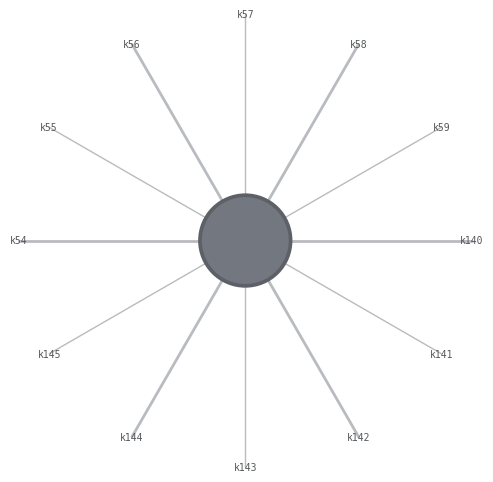

In [72]:
tnc.draw()

In [73]:
tnc

Tensor(shape=(4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2), inds=('k54', 'k55', 'k56', 'k57', 'k58', 'k59', 'k140', 'k141', 'k142', 'k143', 'k144', 'k145'), tags=oset(['I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45', 'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54', 'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72', 'I73', 'I74', 'I75', 'I76', 'I77', 'I78', 'I79', 'I80', 'I81', 'I82', 'I83', 'I84', 'I85', 'I86', 'I87', 'I88', 'I89', 'I90', 'I91', 'I92', 'I93', 'I94', 'I95', 'I96', 'I97', 'I98', 'I99', 'I100', 'I101', 'I102', 'I103', 'I104', 'I105', 'I106', 'I107', 'I108', 'I109', 'I110', 'I111', 'I112', 'I113', 'I114', 'I115', 'I116', 'I117', 'I118', 'I119', 'I120', 'I121', 'I122', 'I123', 'I124', 'I125', 'I126', 'I127', 'I128', 'I129', 'I130', 'I131', 'I132', 'I133', 'I134', 'I135', 'I136', 'I137', 'I138', 'I139', 'I140', 'I141', 'I142', 'I143', 'I144', 'I145', 'I146', 'I147', 'I148', 'I149', 'I150', 'I151', 'I152', 'I153', 'I154', 'I155', 'I156', 'I157', 'I158', 'I159', 'I160', 'I161', 'I162', 'I163', 'I164', 'I165', 'I166', 'I167', 'I168', 'I169', 'I170', 'I171', 'I172', 'I173', 'I174', 'I175', 'I176', 'I177', 'I178', 'I179', 'I180', 'I181', 'I182', 'I183', 'I184', 'I185', 'I186', 'I187', 'I188', 'I189', 'I190', 'I191', 'I192', 'I193', 'I194', 'I195', 'I196', 'I197', 'I198', 'I199', 'J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18', 'J19', 'J20', 'J21', 'J22', 'J23', 'J24', 'J25', 'J26', 'J27', 'J28', 'J29', 'J30', 'J31', 'J32', 'J33', 'J34', 'J35', 'J36', 'J37', 'J38', 'J39', 'J40', 'J41', 'J42', 'J43', 'J44', 'J45', 'J46', 'J47', 'J48', 'J49', 'J50', 'J51', 'J52', 'J53', 'J54', 'J55', 'J56', 'J57', 'J58', 'J59', 'J60', 'J61', 'J62', 'J63', 'J64', 'J65', 'J66', 'J67', 'J68', 'J69', 'J70', 'J71', 'J72', 'J73', 'J74', 'J75', 'J76', 'J77', 'J78', 'J79', 'J80', 'J81', 'J82', 'J83', 'J84', 'J85', 'J86', 'J87', 'J88', 'J89', 'J90', 'J91', 'J92', 'J93', 'J94', 'J95', 'J96', 'J97', 'J98', 'J99', 'J100', 'J101', 'J102', 'J103', 'J104', 'J105', 'J106', 'J107', 'J108', 'J109', 'J110', 'J111', 'J112', 'J113', 'J114', 'J115', 'J116', 'J117', 'J118', 'J119', 'J120', 'J121', 'J122', 'J123', 'J124', 'J125', 'J126', 'J127', 'J128', 'J129', 'J130', 'J131', 'J132', 'J133', 'J134', 'J135', 'J136', 'J137', 'J138', 'J139', 'J140', 'J141', 'J142', 'J143', 'J144', 'J145', 'J146', 'J147', 'J148', 'J149', 'J150', 'J151', 'J152', 'J153', 'J154', 'J155', 'J156', 'J157', 'J158', 'J159', 'J160', 'J161', 'J162', 'J163', 'J164', 'J165', 'J166', 'J167', 'J168', 'J169', 'J170', 'J171', 'J172', 'J173', 'J174', 'J175', 'J176', 'J177', 'J178', 'J179', 'J180', 'J181', 'J182', 'J183', 'J184', 'J185', 'J186', 'J187', 'J188', 'J189', 'J190', 'J191', 'J192', 'J193', 'J194', 'J195', 'J196', 'J197', 'J198', 'J199']))

In [78]:
help(tn.contract_ind)

AttributeError: 'TensorNetwork' object has no attribute 'contract_ind_'

In [76]:
help(tn.contract)

Help on method contract in module quimb.tensor.tensor_core:

contract(tags=Ellipsis, output_inds=None, optimize=None, get=None, max_bond=None, strip_exponent=False, preserve_tensor=False, backend=None, inplace=False, **kwargs) method of quimb.tensor.tensor_core.TensorNetwork instance
    Contract some, or all, of the tensors in this network. This method
    dispatches to ``contract_tags``, ``contract_structured``, or
    ``contract_compressed`` based on the various arguments.
    
    Parameters
    ----------
    tags : sequence of str, all, or Ellipsis, optional
        Any tensors with any of these tags with be contracted. Use ``all``
        or ``...`` (``Ellipsis``) to contract all tensors. ``...`` will try
        and use a 'structured' contract method if possible.
    output_inds : sequence of str, optional
        The indices to specify as outputs of the contraction. If not given,
        and the tensor network has no hyper-indices, these are computed
        automatically as e

In [75]:
tn.tensors

(Tensor(shape=(1, 4), inds=('_51cf92AAAcY', 'k0'), tags=oset(['I0'])),
 Tensor(shape=(1, 2, 2), inds=('_51cf92AAAcY', '_51cf92AAAcZ', 'k1'), tags=oset(['I1'])),
 Tensor(shape=(2, 7, 4), inds=('_51cf92AAAcZ', '_51cf92AAAca', 'k2'), tags=oset(['I2'])),
 Tensor(shape=(7, 8, 2), inds=('_51cf92AAAca', '_51cf92AAAcb', 'k3'), tags=oset(['I3'])),
 Tensor(shape=(8, 8, 4), inds=('_51cf92AAAcb', '_51cf92AAAcc', 'k4'), tags=oset(['I4'])),
 Tensor(shape=(8, 8, 2), inds=('_51cf92AAAcc', '_51cf92AAAcd', 'k5'), tags=oset(['I5'])),
 Tensor(shape=(8, 8, 4), inds=('_51cf92AAAcd', '_51cf92AAAce', 'k6'), tags=oset(['I6'])),
 Tensor(shape=(8, 8, 2), inds=('_51cf92AAAce', '_51cf92AAAcf', 'k7'), tags=oset(['I7'])),
 Tensor(shape=(8, 8, 4), inds=('_51cf92AAAcf', '_51cf92AAAcg', 'k8'), tags=oset(['I8'])),
 Tensor(shape=(8, 8, 2), inds=('_51cf92AAAcg', '_51cf92AAAch', 'k9'), tags=oset(['I9'])),
 Tensor(shape=(8, 8, 4), inds=('_51cf92AAAch', '_51cf92AAAci', 'k10'), tags=oset(['I10'])),
 Tensor(shape=(8, 8, 2), in

# MPOs

In [79]:
help(qtn.MPO_rand)

Help on function MPO_rand in module quimb.tensor.tensor_builder:

MPO_rand(L, bond_dim, phys_dim=2, normalize=True, cyclic=False, herm=False, dtype='float64', dist='normal', loc=0.0, scale=1.0, **mpo_opts)
    Generate a random matrix product state.
    
    Parameters
    ----------
    L : int
        The number of sites.
    bond_dim : int
        The bond dimension.
    phys_dim : int, optional
        The physical (site) dimensions, defaults to 2.
    normalize : bool, optional
        Whether to normalize the operator such that ``trace(A.H @ A) == 1``.
    cyclic : bool, optional
        Generate a MPO with periodic boundary conditions or not, default is
        open boundary conditions.
    dtype : {float, complex} or numpy dtype, optional
        Data type of the tensor network.
    dist : {'normal', 'uniform', 'rademacher', 'exp'}, optional
        Type of random number to generate, defaults to 'normal'.
    loc : float, optional
        An additive offset to add to the random

In [84]:
ml

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

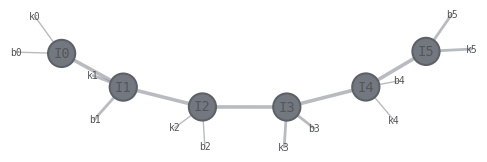

In [86]:
ml.draw()

In [88]:
ml1 = ml.apply(ml.H)

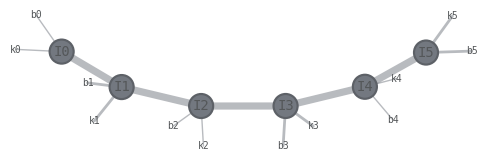

In [89]:
ml1.draw()

In [91]:
ml1.identity()

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=1)

In [102]:
help(ml.apply)

Help on method apply in module quimb.tensor.tensor_1d:

apply(other, compress=False, **compress_opts) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Act with this MPO on another MPO or MPS, such that the resulting
    object has the same tensor network structure/indices as ``other``.
    
    For an MPS::
    
               | | | | | | | | | | | | | | | | | |
         self: A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A
               | | | | | | | | | | | | | | | | | |
        other: x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x
    
                               -->
    
               | | | | | | | | | | | | | | | | | |   <- other.site_ind_id
          out: y=y=y=y=y=y=y=y=y=y=y=y=y=y=y=y=y=y
    
    For an MPO::
    
               | | | | | | | | | | | | | | | | | |
         self: A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A-A
               | | | | | | | | | | | | | | | | | |
        other: B-B-B-B-B-B-B-B-B-B-B-B-B-B-B-B-B-B
               | | | | | | | | | | | | | | | | | |
    
      

In [92]:
def mpo_unitarity(mpo, total_dim):
    x = mpo.apply(mpo.H)

    y = x.apply(x.H)

    out = y.norm(squared=True)

    return out

In [103]:
mpo = ml

In [105]:
t = mpo.combine(mpo.H)

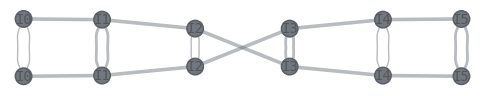

In [106]:
t.draw()

In [117]:
t = mpo.align(mpo.H)

ValueError: Setting the same upper and upper index ids will make the two ambiguous.

In [121]:
ms = [mpo.copy() for _ in range(4)]

In [122]:
ms[0]._upper_ind_id = 'j{}'
ms[0]._lower_ind_id = 'm{}'
ms[1]._upper_ind_id = 'j{}'
ms[1]._lower_ind_id = 'k{}'
ms[2]._upper_ind_id = 'l{}'
ms[2]._lower_ind_id = 'k{}'
ms[3]._upper_ind_id = 'l{}'
ms[3]._lower_ind_id = 'm{}'

In [123]:
ms[0].upper_ind_id = 'j{}'
ms[0].lower_ind_id = 'm{}'
ms[1].upper_ind_id = 'j{}'
ms[1].lower_ind_id = 'k{}'
ms[2].upper_ind_id = 'l{}'
ms[2].lower_ind_id = 'k{}'
ms[3].upper_ind_id = 'l{}'
ms[3].lower_ind_id = 'm{}'

In [124]:
ms[0]

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

In [127]:
t = qtn.tensor_1d.MatrixProductOperator(ml, upper_ind_id='j{}', lower_ind_id='m{}')

In [128]:
t

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

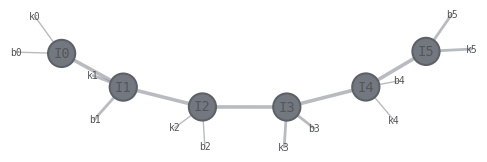

In [120]:
ms[0].draw()

In [113]:
t4 = qtn.TensorNetwork(ms)

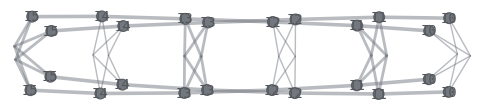

In [114]:
t4.draw()

In [ ]:
m1.set

In [99]:
x = mpo.apply(mpo.H)

In [100]:
x

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=36)

In [101]:
y = x-x.identity()

ValueError: Can only add sum tensor indices of the same size.

In [93]:
mpo_unitarity(ml1)

ValueError: Can only add sum tensor indices of the same size.

In [129]:
ml

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

In [130]:
t = ml._apply_mpo(ml, contract=False)

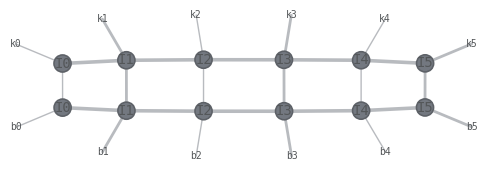

In [131]:
t.draw()

In [132]:
t2 = t._apply_mpo(t, contract=False)

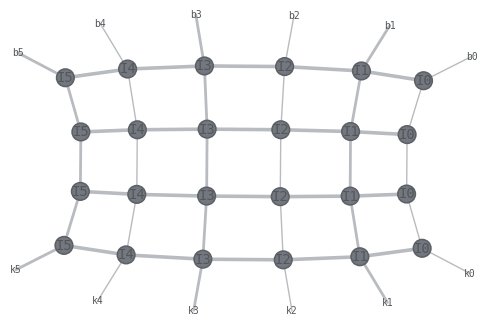

In [134]:
t2.draw()

In [135]:
t2.norm(squared=True)

5.744916917062454e-09

This seems a bit slow... still works though.

In [139]:
ml

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

In [164]:
help(ml.norm)

Help on method norm in module quimb.tensor.tensor_core:

norm(output_inds=None, squared=False, **contract_opts) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Frobenius norm of this tensor network. Computed by exactly
    contracting the TN with its conjugate:
    
    .. math::
    
        \|T\|_F = \sqrt{\mathrm{Tr} \left(T^{\dagger} T\right)}
    
    where the trace is taken over all indices. Equivalent to the square
    root of the sum of squared singular values across any partition.



In [177]:
identity = ml.identity()

In [178]:
unitarity(identity, total_physical_dim)

448.0

In [179]:
mpo = identity

In [181]:
t = mpo._apply_mpo(mpo.H, contract=False)

In [190]:
n1 = mpo.norm(squared=True)

In [191]:
n1

64.0

In [184]:
total_physical_dim

512

In [188]:
n2 = t.norm(squared=True)

In [189]:
n2

64.0

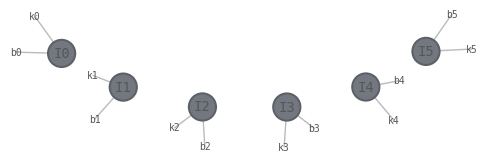

In [193]:
mpo.draw()

In [195]:
ml

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

In [194]:
mpo

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=1)

In [167]:
def unitarity(mpo, total_physical_dim):
    t = mpo._apply_mpo(mpo.H, contract=False)

    n1 = mpo.norm(squared=True)
    n2 = t.norm(squared=True)

    return n2 - 2*n1 + total_physical_dim

In [168]:
total_physical_dim=2**(3*3)

In [169]:
unitarity(ml, total_physical_dim)

510.002046612756

Looks good! (And fast)

## Optomise unitarity

In [170]:
help(qtn.MPO_rand)

Help on function MPO_rand in module quimb.tensor.tensor_builder:

MPO_rand(L, bond_dim, phys_dim=2, normalize=True, cyclic=False, herm=False, dtype='float64', dist='normal', loc=0.0, scale=1.0, **mpo_opts)
    Generate a random matrix product state.
    
    Parameters
    ----------
    L : int
        The number of sites.
    bond_dim : int
        The bond dimension.
    phys_dim : int, optional
        The physical (site) dimensions, defaults to 2.
    normalize : bool, optional
        Whether to normalize the operator such that ``trace(A.H @ A) == 1``.
    cyclic : bool, optional
        Generate a MPO with periodic boundary conditions or not, default is
        open boundary conditions.
    dtype : {float, complex} or numpy dtype, optional
        Data type of the tensor network.
    dist : {'normal', 'uniform', 'rademacher', 'exp'}, optional
        Type of random number to generate, defaults to 'normal'.
    loc : float, optional
        An additive offset to add to the random

In [171]:
ml = qtn.MPO_rand(
    6,
    6,
    phys_dim=[2,4],
    normalize=True
)

In [172]:
sub_unitarity = lambda x: unitarity(x, total_physical_dim)

In [173]:
optmzr = qtn.optimize.TNOptimizer(
    ml,                                # our initial input, the tensors of which to optimize
    loss_fn=sub_unitarity,
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [174]:
ml_opt = optmzr.optimize(100)

-32551325481181600.000000000000 [best: -32551325481181600.000000000000] : : 248it [00:07, 33.90it/s]                                                                                                        


In [196]:
ml_opt

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

In [175]:
unitarity(ml, total_physical_dim)

510.002148845847

In [176]:
unitarity(ml_opt, total_physical_dim)

-3.2551325481181628e+16

In [197]:
mpo = ml_opt

In [198]:
t = mpo._apply_mpo(mpo.H, contract=False)

In [203]:
t.trace()

397442.5668942209

In [199]:
n1 = mpo.norm(squared=True)

In [200]:
n1

2.961456769562728e+16

In [184]:
total_physical_dim

512

In [201]:
n2 = t.norm(squared=True)

In [202]:
n2

2.667780991007242e+16

In [205]:
def unitarity_2(mpo, total_physical_dim):
    t1 = mpo._apply_mpo(mpo.H, contract=False)
    t2 = t1._apply_mpo(mpo, contract=False)
    t3 = t2._apply_mpo(mpo.H, contract=False)
    
    n1 = t1.trace()
    n2 = t3.trace()

    return n2 - 2*n1 + total_physical_dim

In [206]:
unitarity_2(ml_opt, total_physical_dim)

5796447115614.318

In [216]:
ml = qtn.MPO_rand(
    6,
    6,
    phys_dim=[2,4],
    normalize=True
)

In [217]:
t1 = ml._apply_mpo(ml.H, contract=False)

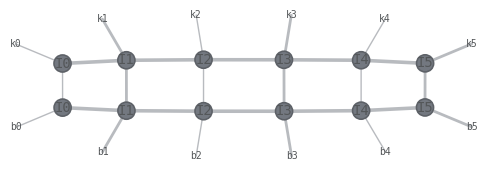

In [218]:
t1.draw()

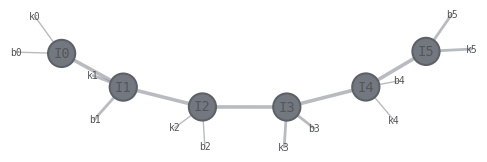

In [219]:
ml.draw()

In [209]:
sub_unitarity = lambda x: unitarity_2(x, total_physical_dim)

In [210]:
optmzr = qtn.optimize.TNOptimizer(
    ml,                                # our initial input, the tensors of which to optimize
    loss_fn=sub_unitarity,
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [211]:
ml_opt = optmzr.optimize(100)

+nan [best: -125145244153282.937500000000] :  55%|██████████████████████████████████████████████████████████████████▌                                                      | 55/100 [00:01<00:01, 28.51it/s]


In [212]:
unitarity_2(ml_opt, total_physical_dim)

-125145244153283.38

In [215]:
help(ml_opt.conj)

Help on method conj in module quimb.tensor.tensor_core:

conj(mangle_inner=False, output_inds=None, inplace=False) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Conjugate all the tensors in this network (leave all outer indices).
    
    Parameters
    ----------
    mangle_inner : {bool, str, None}, optional
        Whether to mangle the inner indices of the network. If a string is
        given, it will be appended to the index names.
    output_inds : sequence of str, optional
        If given, the indices to mangle will be restricted to those not in
        this list. This is only needed for (hyper) tensor networks where
        output indices are not given simply by those that appear once.
    inplace : bool, optional
        Whether to perform the conjugation inplace or not.
    
    Returns
    -------
    TensorNetwork



In [220]:
ml_opt

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

In [221]:
help(ml_opt.trace)

Help on method trace in module quimb.tensor.tensor_1d:

trace(left_inds=None, right_inds=None) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Take the trace of this MPO.



In [222]:
ml_opt.trace(
    [f'k{i}' for i in range(6)],
    [f'b{i}' for i in range(6)]
)

556.341377987648

In [223]:
ml_opt.trace()

556.341377987648

In [236]:
help(ml_opt.flip)

Help on method flip in module quimb.tensor.tensor_core:

flip(inds, inplace=False) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Flip the dimension corresponding to indices ``inds`` on all tensors
    that share it.



In [237]:
help(ml_opt.reindex)

Help on method reindex in module quimb.tensor.tensor_core:

reindex(index_map, inplace=False) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Rename indices for all tensors in this network, optionally in-place.
    
    Parameters
    ----------
    index_map : dict-like
        Mapping of pairs ``{old_ind: new_ind, ...}``.



In [238]:
help(ml_opt.reindex)

Help on method reindex in module quimb.tensor.tensor_core:

reindex(index_map, inplace=False) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Rename indices for all tensors in this network, optionally in-place.
    
    Parameters
    ----------
    index_map : dict-like
        Mapping of pairs ``{old_ind: new_ind, ...}``.



In [239]:
help(ml_opt.conj)

Help on method conj in module quimb.tensor.tensor_core:

conj(mangle_inner=False, output_inds=None, inplace=False) method of quimb.tensor.tensor_1d.MatrixProductOperator instance
    Conjugate all the tensors in this network (leave all outer indices).
    
    Parameters
    ----------
    mangle_inner : {bool, str, None}, optional
        Whether to mangle the inner indices of the network. If a string is
        given, it will be appended to the index names.
    output_inds : sequence of str, optional
        If given, the indices to mangle will be restricted to those not in
        this list. This is only needed for (hyper) tensor networks where
        output indices are not given simply by those that appear once.
    inplace : bool, optional
        Whether to perform the conjugation inplace or not.
    
    Returns
    -------
    TensorNetwork



In [246]:
from itertools import chain

In [245]:
dict(*zip(indices_1, indices_2))

TypeError: dict expected at most 1 argument, got 6

In [247]:
indices_1 = [f'k{i}' for i in range(6)]
indices_2 = [f'b{i}' for i in range(6)]
mapping = dict(chain(zip(indices_1, indices_2), zip(indices_2, indices_1)))
ml_opt_h = ml_opt.reindex(mapping).conj()

In [248]:
t1 = ml_opt.apply(ml_opt_h)

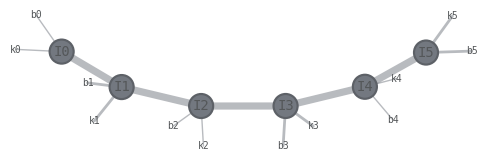

In [249]:
t1.draw()

In [250]:
t1.trace()

15393927887.427805

In [233]:
ml_opt.norm(squared=True)

15393927887.427805

In [229]:
(ml_opt.norm()**2)

15393927887.427805

In [15]:
def hermitian_conjugate_mpo(mpo):
    indices_1 = [f'k{i}' for i in range(len(mpo.tensors))]
    indices_2 = [f'b{i}' for i in range(len(mpo.tensors))]

    mapping = dict(
        chain(
            zip(indices_1, indices_2),
            zip(indices_2, indices_1)
        )
    )
    
    mpo_h = mpo.reindex(mapping).conj()

    return mpo_h

In [16]:
def unitarity_3(mpo, total_physical_dim):
    mpo_h = hermitian_conjugate_mpo(mpo)
    
    t1 = mpo._apply_mpo(mpo_h, contract=False)
    t2 = t1._apply_mpo(mpo, contract=False)
    t3 = t2._apply_mpo(mpo_h, contract=False)
    
    n1 = t1.trace()
    n2 = t3.trace()

    return n2 - 2*n1 + total_physical_dim

In [254]:
ml = qtn.MPO_rand(
    6,
    6,
    phys_dim=[2,4],
    normalize=True
)

In [60]:
sub_unitarity = lambda x: unitarity_3(x, total_physical_dim)

In [257]:
optmzr = qtn.optimize.TNOptimizer(
    ml,                                # our initial input, the tensors of which to optimize
    loss_fn=sub_unitarity,
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [258]:
ml_opt = optmzr.optimize(100)

+0.249141987334 [best: +0.249141987334] : : 121it [00:03, 36.15it/s]                                                                                                                                        


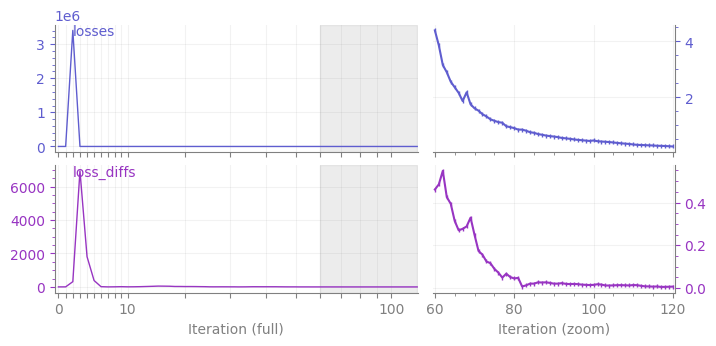

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [260]:
optmzr.plot()

In [259]:
unitarity_3(ml_opt, total_physical_dim)

0.2491419873349514

Looks good! Now add the overlap loss.

## Overlap optimisation
Do the contractions "stupidly" first, optomise later if needed.

In [14]:
q1

MatrixProductState(tensors=200, indices=399, L=200, max_bond=8)

In [15]:
q2 = q1.copy(deep=True)

In [16]:
help(q1.align)

Help on method tensor_network_align in module quimb.tensor.tensor_arbgeom:

tensor_network_align(*tns: 'TensorNetworkGen', ind_ids=None, trace=False, inplace=False) method of quimb.tensor.tensor_1d.MatrixProductState instance
    Align an arbitrary number of tensor networks in a stack-like geometry::
    
        a-a-a-a-a-a-a-a-a-a-a-a-a-a-a-a-a-a
        | | | | | | | | | | | | | | | | | | <- ind_ids[0] (defaults to 1st id)
        b-b-b-b-b-b-b-b-b-b-b-b-b-b-b-b-b-b
        | | | | | | | | | | | | | | | | | | <- ind_ids[1]
                       ...
        | | | | | | | | | | | | | | | | | | <- ind_ids[-2]
        y-y-y-y-y-y-y-y-y-y-y-y-y-y-y-y-y-y
        | | | | | | | | | | | | | | | | | | <- ind_ids[-1]
        z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z
    
    Parameters
    ----------
    tns : sequence of TensorNetwork
        The TNs to align, should be structured and either effective 'vectors'
        (have a ``site_ind_id``) or 'operators' (have a ``up_ind_id`` and
        ``lo

In [23]:
for i in range(60, 140, 2):

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

In [24]:
mpo_l = qtn.MPO_rand(
    6,
    6,
    phys_dim=[2,4],
    normalize=True
)

# Hard code warning!
kl_map = {f'k{i}':f'k{i+54}' for i in range(mpo_l.L)}
bl_map = {f'b{i}':f'b{i+54}' for i in range(mpo_l.L)}

mpo_l.reindex({**kl_map, **bl_map}, inplace=True)

mpo_r = qtn.MPO_rand(
    6,
    6,
    phys_dim=[2,4],
    normalize=True
)

kr_map = {f'k{i}':f'k{i+140}' for i in range(mpo_r.L)}
br_map = {f'b{i}':f'b{i+140}' for i in range(mpo_r.L)}

mpo_r.reindex({**kr_map, **br_map}, inplace=True)

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

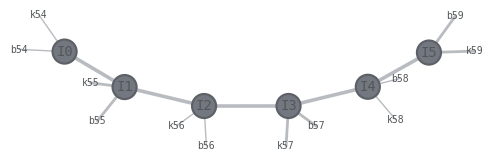

In [25]:
mpo_l.draw()

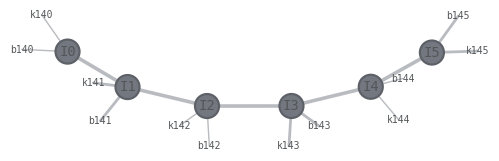

In [26]:
mpo_r.draw()

In [27]:
t = mpo_l.apply(q2, contract=False)

In [28]:
t1 = mpo_r.apply(t, contract=False)

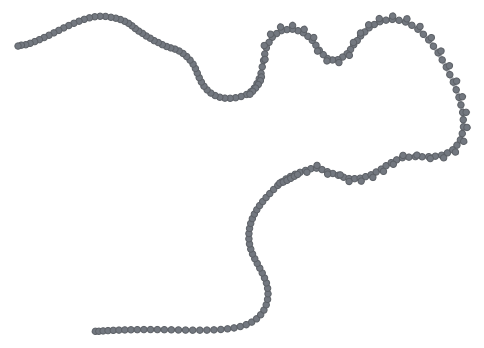

In [29]:
t1.draw()

In [30]:
type(t1)

quimb.tensor.tensor_1d.MatrixProductState

In [31]:
q1.H

MatrixProductState(tensors=200, indices=399, L=200, max_bond=8)

In [ ]:
(t1 & q1.H) ^ ...

In [ ]:
help(t1.al

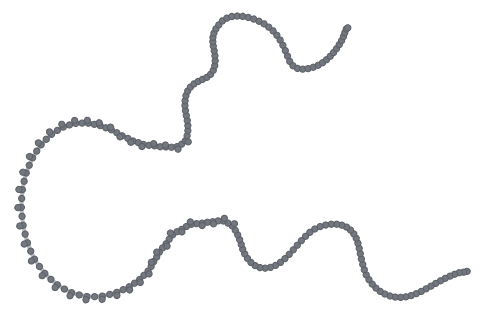

In [294]:
q2.draw()

In [295]:
q2

MatrixProductState(tensors=240, indices=439, L=200, max_bond=8)

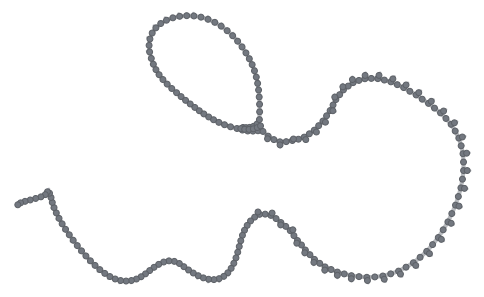

In [292]:
t.draw()

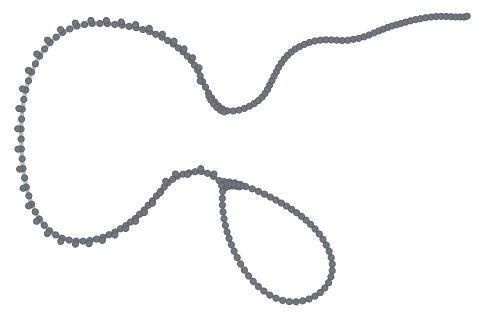

In [291]:
t1.draw()

In [290]:
t1.overlap(q1)

ValueError: Dimension mismatch between axes 2 of (1, 2, 2) and 3 of (6, 6, 4, 4): 2 != 4.

In [ ]:
def overlap_loss(left_mpo, right_mpo):
    t = left_mpo.apply(q2, contract=False)
    t1 = right_mpo.apply(t, contract=False)

    overlapp = 

Try old approach.

In [50]:
q2 = q1.copy()

In [51]:
for i in range(60, 140, 2):

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

In [52]:
q2

MatrixProductState(tensors=240, indices=439, L=200, max_bond=8)

In [53]:
num_sites = 6
num_symmetry_sites = 80
num_psi_sites = psi.L
left_most_symmetry_site=60

sites_to_contract = (
    list(range(left_most_symmetry_site-num_sites))
    + list(range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites))
    + list(range(left_most_symmetry_site+num_symmetry_sites+num_sites, num_psi_sites))
)

In [54]:
tags_to_contract = [f'I{i}' for i in sites_to_contract]

In [55]:
tn = q2.H & q1

In [56]:
tnc = tn ^ tags_to_contract

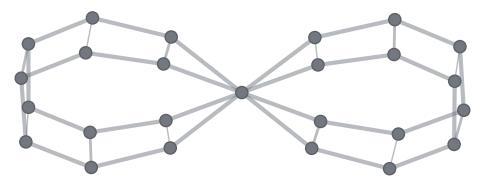

In [57]:
tnc.draw()

In [31]:
tnc

TensorNetwork1D(tensors=25, indices=40, L=200, max_bond=8)

In [32]:
tn = q1.H & q1

In [33]:
tnc = tn ^ tags_to_contract

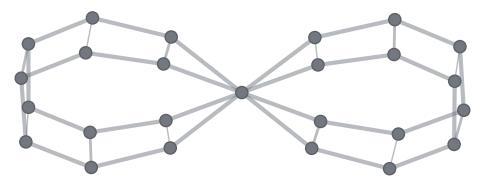

In [34]:
tnc.draw()

In [31]:
tnc

TensorNetwork1D(tensors=25, indices=40, L=200, max_bond=8)

In [37]:
t = q1.tensors[0]

In [38]:
t.inds

('_1b5e08AAAAB', 'k0')

In [40]:
inds_to_find = (tnc.tensors[-1]).inds

In [41]:
inds_to_find

('_1b5e08AAABC',
 '_1b5e08AAABI',
 '_1b5e08AAACk',
 '_1b5e08AAACq',
 '_1b5e08AAANP',
 '_1b5e08AAANV',
 '_1b5e08AAAOx',
 '_1b5e08AAAPD')

In [42]:
bad_tensors = [
    t for t in q1.tensors
    if any(i in t.inds for i in inds_to_find)
]

In [43]:
bad_tensors

[Tensor(shape=(8, 8, 2), inds=('_1b5e08AAABB', '_1b5e08AAABC', 'k53'), tags=oset(['I53'])),
 Tensor(shape=(8, 8, 4), inds=('_1b5e08AAABC', '_1b5e08AAABD', 'k54'), tags=oset(['I54'])),
 Tensor(shape=(8, 8, 2), inds=('_1b5e08AAABH', '_1b5e08AAABI', 'k59'), tags=oset(['I59'])),
 Tensor(shape=(8, 8, 4), inds=('_1b5e08AAABI', '_1b5e08AAABJ', 'k60'), tags=oset(['I60'])),
 Tensor(shape=(8, 8, 2), inds=('_1b5e08AAACj', '_1b5e08AAACk', 'k139'), tags=oset(['I139'])),
 Tensor(shape=(8, 8, 4), inds=('_1b5e08AAACk', '_1b5e08AAACl', 'k140'), tags=oset(['I140'])),
 Tensor(shape=(8, 8, 2), inds=('_1b5e08AAACp', '_1b5e08AAACq', 'k145'), tags=oset(['I145'])),
 Tensor(shape=(8, 8, 4), inds=('_1b5e08AAACq', '_1b5e08AAACr', 'k146'), tags=oset(['I146']))]

In [46]:
sub_tags_to_contract = [
    f'I{i}' for i in range(200)
    if i != 100
]

In [47]:
tnc = tn ^ sub_tags_to_contract

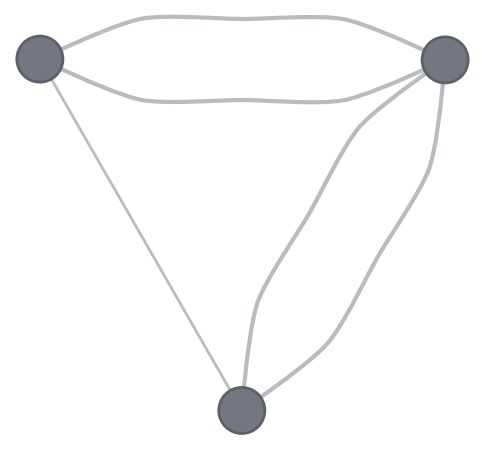

In [48]:
tnc.draw()

In [49]:
tnc.tensors

(Tensor(shape=(8, 8, 4), inds=('_1b5e08AAABw', '_1b5e08AAABx', 'k100'), tags=oset(['I100'])),
 Tensor(shape=(8, 8, 4), inds=('_1b5e08AAAOJ', '_1b5e08AAAOK', 'k100'), tags=oset(['I100'])),
 Tensor(shape=(8, 8, 8, 8), inds=('_1b5e08AAABw', '_1b5e08AAABx', '_1b5e08AAAOJ', '_1b5e08AAAOK'), tags=oset(['I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45', 'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54', 'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72', 'I73', 'I74', 'I75', 'I76', 'I77', 'I78', 'I79', 'I80', 'I81', 'I82', 'I83', 'I84', 'I85', 'I86', 'I87', 'I88', 'I89', 'I90', 'I91', 'I92', 'I93', 'I94', 'I95', 'I96', 'I97', 'I98', 'I99', 'I101', 'I10

In [17]:
q2 = q1.copy(deep=True)
qb = q1.copy()

In [18]:
for i in range(60, 140, 2):

    q2.gate(
        np_10,
        where=i,
        contract=False,
        inplace=True
    )

ERROR! Session/line number was not unique in database. History logging moved to new session 4


In [19]:
from itertools import chain

In [20]:
indices_to_map = list(chain(range(60-6,60), range(140, 140+6)))

In [21]:
indices_to_map

[54, 55, 56, 57, 58, 59, 140, 141, 142, 143, 144, 145]

In [22]:
index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

In [23]:
qb.reindex(index_mapping, inplace=True)

MatrixProductState(tensors=200, indices=399, L=200, max_bond=8)

In [24]:
num_sites = 6
num_symmetry_sites = 80
num_psi_sites = psi.L
left_most_symmetry_site=60

sites_to_contract = (
    list(range(left_most_symmetry_site-num_sites))
    + list(range(left_most_symmetry_site, left_most_symmetry_site+num_symmetry_sites))
    + list(range(left_most_symmetry_site+num_symmetry_sites+num_sites, num_psi_sites))
)

In [25]:
tags_to_contract = [f'I{i}' for i in sites_to_contract]

In [26]:
tn = q2 & qb

In [27]:
tnc = tn ^ tags_to_contract

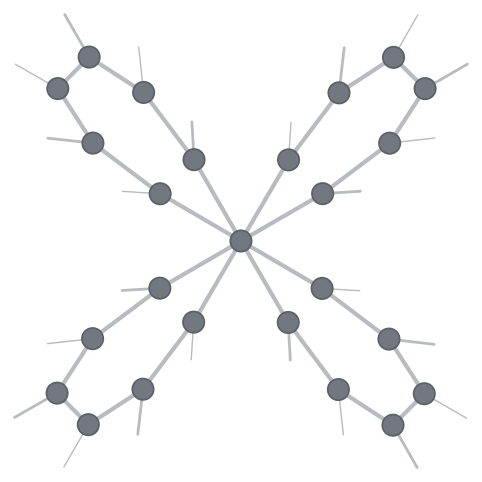

In [28]:
tnc.draw()

In [30]:
ml = qtn.MPO_rand(
    6,
    6,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(54, 60)),
    tags='left_mpo'
)

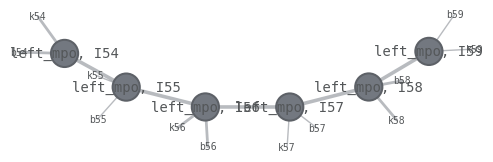

In [31]:
ml.draw()

In [32]:
mr = qtn.MPO_rand(
    6,
    6,
    phys_dim=[4,2],
    normalize=True,
    sites=list(range(140,146)),
    tags='right_mpo'
)

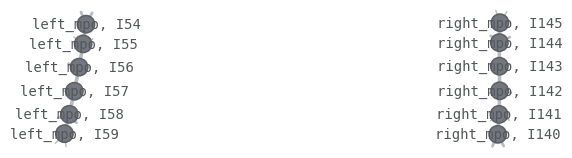

In [33]:
ml.combine(mr).draw()

In [34]:
mpo = ml.combine(mr)

In [35]:
mpo

TensorNetwork1D(tensors=12, indices=34, L=6, max_bond=6)

In [117]:
mpo = ml & mr

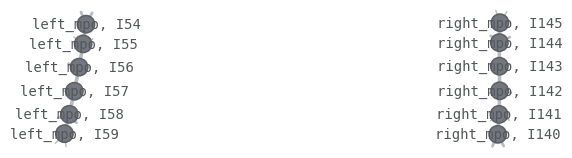

In [37]:
mpo.draw()

In [38]:
mpo.tensor_map

{0: Tensor(shape=(6, 4, 4), inds=('_53b32dAAAIj', 'k54', 'b54'), tags=oset(['left_mpo', 'I54'])),
 1: Tensor(shape=(6, 6, 2, 2), inds=('_53b32dAAAIj', '_53b32dAAAIk', 'k55', 'b55'), tags=oset(['left_mpo', 'I55'])),
 2: Tensor(shape=(6, 6, 4, 4), inds=('_53b32dAAAIk', '_53b32dAAAIl', 'k56', 'b56'), tags=oset(['left_mpo', 'I56'])),
 3: Tensor(shape=(6, 6, 2, 2), inds=('_53b32dAAAIl', '_53b32dAAAIm', 'k57', 'b57'), tags=oset(['left_mpo', 'I57'])),
 4: Tensor(shape=(6, 6, 4, 4), inds=('_53b32dAAAIm', '_53b32dAAAIn', 'k58', 'b58'), tags=oset(['left_mpo', 'I58'])),
 5: Tensor(shape=(6, 2, 2), inds=('_53b32dAAAIn', 'k59', 'b59'), tags=oset(['left_mpo', 'I59'])),
 6: Tensor(shape=(6, 4, 4), inds=('_53b32dAAAIu', 'k140', 'b140'), tags=oset(['right_mpo', 'I140'])),
 7: Tensor(shape=(6, 6, 2, 2), inds=('_53b32dAAAIu', '_53b32dAAAIv', 'k141', 'b141'), tags=oset(['right_mpo', 'I141'])),
 8: Tensor(shape=(6, 6, 4, 4), inds=('_53b32dAAAIv', '_53b32dAAAIw', 'k142', 'b142'), tags=oset(['right_mpo', 'I1

In [40]:
tno = (tnc & mpo)

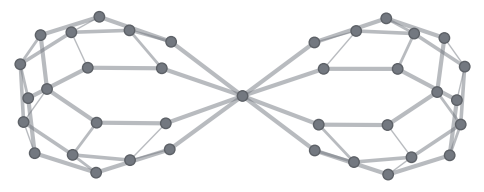

In [41]:
tno.draw()

In [42]:
tno ^ ...

(-4.1243316381788274e-19-2.1570263945784565e-19j)

In [43]:
from math import sqrt

In [94]:
def overlap_loss_function(ml, mr):
    c = (tnc & ml & mr) ^ ...

    c_abs = abs(c)

    loss = (c_abs - 1)**2

    return loss

In [96]:
overlap_loss_function(ml, mr)

1.0

In [47]:
total_physical_dimension=2**9

In [62]:
ml

MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=6)

In [66]:
regex_s = r"^I\d+$"

In [67]:
import re

In [68]:
regex_p = re.compile(regex_s)

In [70]:
m = regex_p.match('I99')

In [75]:
m[0]

'I99'

In [76]:
bool(re.search(regex_p, "abcdefghijkl"))

False

In [77]:
bool(re.search(regex_p, "I99"))

True

In [65]:
ml.tag_map

{'left_mpo': oset([0, 1, 2, 3, 4, 5]),
 'I54': oset([0]),
 'I55': oset([1]),
 'I56': oset([2]),
 'I57': oset([3]),
 'I58': oset([4]),
 'I59': oset([5])}

In [78]:
site_locs = [
    int(k[1:]) for k in ml.tag_map
    if bool(re.search(regex_p, k))
]

In [79]:
site_locs

[54, 55, 56, 57, 58, 59]

In [ ]:
ms = [ml.copy(), ml.copy(), ml.copy()]

In [80]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [84]:
tn = ml

In [85]:
ms = [tn.copy(), tn.copy(), tn.copy()]

relabel_mpo(ms[0], 'k', 'l')
relabel_mpo(ms[1], 'm', 'l')
relabel_mpo(ms[2], 'm', 'b')

ms[0] = ms[0].conj()
ms[2] = ms[2].conj()

In [86]:
n2 = (tn & tn.conj())

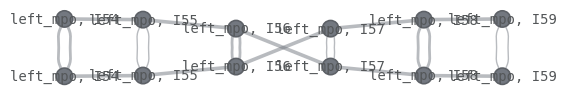

In [87]:
n2.draw()

In [91]:
n4 = (tn & ms[0] & ms[1] & ms[2])

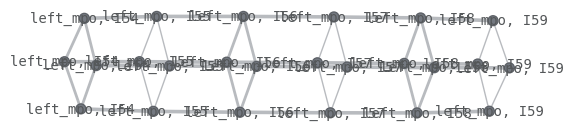

In [92]:
n4.draw()

wtf

In [106]:
n2.contract(n2.tag_map)

1.0000000000000004

In [99]:
n4 ^ 'left_mpo'

0.009986860506757875

In [93]:
n4 ^ ...

TensorNetwork1D(tensors=24, indices=44, L=6, max_bond=6)

In [90]:
n2.contract()

TensorNetwork1D(tensors=12, indices=22, L=6, max_bond=6)

In [88]:
n2 ^ ...

TensorNetwork1D(tensors=12, indices=22, L=6, max_bond=6)

In [107]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    return n4 - 2*n2 + total_physical_dim

In [108]:
unitarity_tn(ml, total_physical_dim)

510.00998686050673

In [126]:
def overall_loss_function(mpo):
    ml = qtn.TensorNetwork(
        list(map(mpo.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )
    mr = qtn.TensorNetwork(
        list(map(mpo.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )
    o_loss = overlap_loss_function(ml, mr)
    ul_loss = unitarity_tn(ml, total_physical_dimension)
    ur_loss = unitarity_tn(mr, total_physical_dimension)

    out = ul_loss + ur_loss + 50*o_loss

    return out

In [124]:
ml1 = qtn.TensorNetwork(
    list(map(mpo.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
)
mr2 = qtn.TensorNetwork(
    list(map(mpo.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
)

In [127]:
overall_loss_function(mpo)

1070.0204194369367

In [128]:
optmzr = qtn.optimize.TNOptimizer(
    mpo,                                # our initial input, the tensors of which to optimize
    loss_fn=overall_loss_function,
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

In [129]:
total_physical_dim = 2**9

In [130]:
mpo = optmzr.optimize(100)

  0%|                                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

+1070.020419436937 [best: +1070.020419436937] :   1%|█▏                                                                                                                     | 1/100 [00:02<04:27,  2.70s/it]

+1042.968407497600 [best: +1042.968407497600] :   2%|██▍                                                                                                                    | 2/100 [00:04<03:44,  2.29s/it]

+331178.144365104672 [best: +1042.968407497600] :   3%|███▌                                                                                                                 | 3/100 [00:06<03:23,  2.10s/it]

+952.157981652506 [best: +952.157981652506] :   4%|████▊                                                                                                                    | 4/100 [00:08<03:16,  2.04s/it]

+972.005834621293 [best: +952.157981652506] :   5%|██████                                                                                                                   | 5/100 [00:10<03:17,  2.07s/it]

+951.771610430552 [best: +951.771610430552] :   6%|███████▎                                                                                                                 | 6/100 [00:12<03:08,  2.00s/it]

+535526.343742615194 [best: +951.771610430552] :   7%|████████▎                                                                                                             | 7/100 [00:14<03:05,  1.99s/it]

+1769.415707764347 [best: +951.771610430552] :   8%|█████████▌                                                                                                              | 8/100 [00:16<03:06,  2.03s/it]

+953.551194505054 [best: +951.771610430552] :   9%|██████████▉                                                                                                              | 9/100 [00:18<02:59,  1.98s/it]

+951.719682560786 [best: +951.719682560786] :  10%|████████████                                                                                                            | 10/100 [00:20<02:53,  1.93s/it]

+939.729988799722 [best: +939.729988799722] :  11%|█████████████▏                                                                                                          | 11/100 [00:22<02:57,  1.99s/it]

+1601.767827536909 [best: +939.729988799722] :  12%|██████████████▎                                                                                                        | 12/100 [00:24<02:52,  1.96s/it]

+895.896761088729 [best: +895.896761088729] :  13%|███████████████▌                                                                                                        | 13/100 [00:26<02:47,  1.93s/it]

+951.773618575063 [best: +895.896761088729] :  14%|████████████████▊                                                                                                       | 14/100 [00:28<02:58,  2.07s/it]

+857.031510594587 [best: +857.031510594587] :  15%|██████████████████                                                                                                      | 15/100 [00:30<02:52,  2.03s/it]

+787.782181241712 [best: +787.782181241712] :  16%|███████████████████▏                                                                                                    | 16/100 [00:32<02:49,  2.01s/it]

+717.645391202292 [best: +717.645391202292] :  17%|████████████████████▍                                                                                                   | 17/100 [00:34<02:52,  2.08s/it]

+678.606718235099 [best: +678.606718235099] :  18%|█████████████████████▌                                                                                                  | 18/100 [00:36<02:52,  2.11s/it]

+659.967140004491 [best: +659.967140004491] :  19%|██████████████████████▊                                                                                                 | 19/100 [00:38<02:46,  2.05s/it]

+652.984478157503 [best: +652.984478157503] :  20%|████████████████████████                                                                                                | 20/100 [00:41<02:49,  2.12s/it]

+612.155422836770 [best: +612.155422836770] :  21%|█████████████████████████▏                                                                                              | 21/100 [00:43<02:47,  2.12s/it]

+560.875616354295 [best: +560.875616354295] :  22%|██████████████████████████▍                                                                                             | 22/100 [00:45<02:40,  2.06s/it]

+530.332578114148 [best: +530.332578114148] :  23%|███████████████████████████▌                                                                                            | 23/100 [00:47<02:37,  2.05s/it]

+488.023356340626 [best: +488.023356340626] :  24%|████████████████████████████▊                                                                                           | 24/100 [00:49<02:36,  2.06s/it]

+461.128640623077 [best: +461.128640623077] :  25%|██████████████████████████████                                                                                          | 25/100 [00:51<02:32,  2.04s/it]

+439.210833967042 [best: +439.210833967042] :  26%|███████████████████████████████▏                                                                                        | 26/100 [00:53<02:29,  2.02s/it]

+410.099427666984 [best: +410.099427666984] :  27%|████████████████████████████████▍                                                                                       | 27/100 [00:55<02:28,  2.03s/it]

+394.827538795868 [best: +394.827538795868] :  28%|█████████████████████████████████▌                                                                                      | 28/100 [00:57<02:26,  2.04s/it]

+368.389150549569 [best: +368.389150549569] :  29%|██████████████████████████████████▊                                                                                     | 29/100 [00:59<02:28,  2.09s/it]

+333.755114941676 [best: +333.755114941676] :  30%|████████████████████████████████████                                                                                    | 30/100 [01:01<02:29,  2.14s/it]

+317.233662721113 [best: +317.233662721113] :  31%|█████████████████████████████████████▏                                                                                  | 31/100 [01:04<02:32,  2.21s/it]

+296.964402432946 [best: +296.964402432946] :  32%|██████████████████████████████████████▍                                                                                 | 32/100 [01:06<02:38,  2.33s/it]

+285.316340810649 [best: +285.316340810649] :  33%|███████████████████████████████████████▌                                                                                | 33/100 [01:08<02:31,  2.26s/it]

+265.750408650500 [best: +265.750408650500] :  34%|████████████████████████████████████████▊                                                                               | 34/100 [01:10<02:23,  2.17s/it]

+248.925908229161 [best: +248.925908229161] :  35%|██████████████████████████████████████████                                                                              | 35/100 [01:13<02:23,  2.21s/it]

+223.640440586726 [best: +223.640440586726] :  36%|███████████████████████████████████████████▏                                                                            | 36/100 [01:15<02:25,  2.27s/it]

+201.974490044122 [best: +201.974490044122] :  37%|████████████████████████████████████████████▍                                                                           | 37/100 [01:17<02:20,  2.23s/it]

+186.812987923123 [best: +186.812987923123] :  38%|█████████████████████████████████████████████▌                                                                          | 38/100 [01:19<02:18,  2.24s/it]

+162.441400398843 [best: +162.441400398843] :  39%|██████████████████████████████████████████████▊                                                                         | 39/100 [01:21<02:13,  2.19s/it]

+141.890978562288 [best: +141.890978562288] :  40%|████████████████████████████████████████████████                                                                        | 40/100 [01:24<02:10,  2.18s/it]

+120.806701362161 [best: +120.806701362161] :  41%|█████████████████████████████████████████████████▏                                                                      | 41/100 [01:26<02:10,  2.21s/it]

+112.155146029024 [best: +112.155146029024] :  42%|██████████████████████████████████████████████████▍                                                                     | 42/100 [01:28<02:07,  2.20s/it]

+98.653433534133 [best: +98.653433534133] :  43%|████████████████████████████████████████████████████▍                                                                     | 43/100 [01:30<02:03,  2.16s/it]

+90.761633014708 [best: +90.761633014708] :  44%|█████████████████████████████████████████████████████▋                                                                    | 44/100 [01:32<02:03,  2.21s/it]

+82.042390347575 [best: +82.042390347575] :  45%|██████████████████████████████████████████████████████▉                                                                   | 45/100 [01:35<01:59,  2.17s/it]

+73.334937850265 [best: +73.334937850265] :  46%|████████████████████████████████████████████████████████                                                                  | 46/100 [01:37<01:57,  2.18s/it]

+66.344211827704 [best: +66.344211827704] :  47%|█████████████████████████████████████████████████████████▎                                                                | 47/100 [01:39<02:00,  2.27s/it]

+62.971416573119 [best: +62.971416573119] :  48%|██████████████████████████████████████████████████████████▌                                                               | 48/100 [01:41<01:57,  2.26s/it]

+61.270070336612 [best: +61.270070336612] :  49%|███████████████████████████████████████████████████████████▊                                                              | 49/100 [01:44<01:58,  2.32s/it]

+60.279907272292 [best: +60.279907272292] :  50%|█████████████████████████████████████████████████████████████                                                             | 50/100 [01:46<01:56,  2.33s/it]

+58.206672918570 [best: +58.206672918570] :  51%|██████████████████████████████████████████████████████████████▏                                                           | 51/100 [01:49<01:52,  2.29s/it]

+56.382062463091 [best: +56.382062463091] :  52%|███████████████████████████████████████████████████████████████▍                                                          | 52/100 [01:51<01:54,  2.39s/it]

+55.073445275288 [best: +55.073445275288] :  53%|████████████████████████████████████████████████████████████████▋                                                         | 53/100 [01:54<01:52,  2.39s/it]

+54.486313698357 [best: +54.486313698357] :  54%|█████████████████████████████████████████████████████████████████▉                                                        | 54/100 [01:56<01:46,  2.31s/it]

+53.969341192614 [best: +53.969341192614] :  55%|███████████████████████████████████████████████████████████████████                                                       | 55/100 [01:58<01:45,  2.35s/it]

+53.499872681849 [best: +53.499872681849] :  56%|████████████████████████████████████████████████████████████████████▎                                                     | 56/100 [02:00<01:42,  2.33s/it]

+53.158386915951 [best: +53.158386915951] :  57%|█████████████████████████████████████████████████████████████████████▌                                                    | 57/100 [02:03<01:38,  2.29s/it]

+52.812235672421 [best: +52.812235672421] :  58%|██████████████████████████████████████████████████████████████████████▊                                                   | 58/100 [02:05<01:38,  2.34s/it]

+52.555564479016 [best: +52.555564479016] :  59%|███████████████████████████████████████████████████████████████████████▉                                                  | 59/100 [02:07<01:34,  2.31s/it]

+52.317028930909 [best: +52.317028930909] :  60%|█████████████████████████████████████████████████████████████████████████▏                                                | 60/100 [02:10<01:32,  2.31s/it]

+52.158737620084 [best: +52.158737620084] :  61%|██████████████████████████████████████████████████████████████████████████▍                                               | 61/100 [02:12<01:30,  2.33s/it]

+51.971344045159 [best: +51.971344045159] :  62%|███████████████████████████████████████████████████████████████████████████▋                                              | 62/100 [02:14<01:27,  2.29s/it]

+51.828010273170 [best: +51.828010273170] :  63%|████████████████████████████████████████████████████████████████████████████▊                                             | 63/100 [02:17<01:26,  2.35s/it]

+51.614516787882 [best: +51.614516787882] :  64%|██████████████████████████████████████████████████████████████████████████████                                            | 64/100 [02:19<01:24,  2.36s/it]

+51.537833571571 [best: +51.537833571571] :  65%|███████████████████████████████████████████████████████████████████████████████▎                                          | 65/100 [02:21<01:20,  2.30s/it]

+51.431077427936 [best: +51.431077427936] :  66%|████████████████████████████████████████████████████████████████████████████████▌                                         | 66/100 [02:24<01:20,  2.36s/it]

+51.261471341781 [best: +51.261471341781] :  67%|█████████████████████████████████████████████████████████████████████████████████▋                                        | 67/100 [02:26<01:17,  2.35s/it]

+51.424915189329 [best: +51.261471341781] :  68%|██████████████████████████████████████████████████████████████████████████████████▉                                       | 68/100 [02:28<01:15,  2.37s/it]

+51.188231472460 [best: +51.188231472460] :  69%|████████████████████████████████████████████████████████████████████████████████████▏                                     | 69/100 [02:31<01:14,  2.40s/it]

+51.088646493866 [best: +51.088646493866] :  70%|█████████████████████████████████████████████████████████████████████████████████████▍                                    | 70/100 [02:33<01:11,  2.39s/it]

+51.024476128186 [best: +51.024476128186] :  71%|██████████████████████████████████████████████████████████████████████████████████████▌                                   | 71/100 [02:36<01:08,  2.38s/it]

+50.963226945562 [best: +50.963226945562] :  72%|███████████████████████████████████████████████████████████████████████████████████████▊                                  | 72/100 [02:38<01:06,  2.38s/it]

+50.885967241429 [best: +50.885967241429] :  73%|█████████████████████████████████████████████████████████████████████████████████████████                                 | 73/100 [02:40<01:02,  2.33s/it]

+50.836269597821 [best: +50.836269597821] :  74%|██████████████████████████████████████████████████████████████████████████████████████████▎                               | 74/100 [02:43<01:01,  2.37s/it]

+50.792978466332 [best: +50.792978466332] :  75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 75/100 [02:45<00:58,  2.35s/it]

+50.731434227037 [best: +50.731434227037] :  76%|████████████████████████████████████████████████████████████████████████████████████████████▋                             | 76/100 [02:47<00:55,  2.30s/it]

+50.685848402171 [best: +50.685848402171] :  77%|█████████████████████████████████████████████████████████████████████████████████████████████▉                            | 77/100 [02:50<00:54,  2.37s/it]

+50.650048868955 [best: +50.650048868955] :  78%|███████████████████████████████████████████████████████████████████████████████████████████████▏                          | 78/100 [02:53<00:57,  2.62s/it]

+50.627201010581 [best: +50.627201010581] :  79%|████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 79/100 [02:56<00:57,  2.73s/it]

+50.596362144013 [best: +50.596362144013] :  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 80/100 [02:58<00:52,  2.62s/it]

+50.578846925217 [best: +50.578846925217] :  81%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 81/100 [03:00<00:47,  2.50s/it]

+50.537502503054 [best: +50.537502503054] :  82%|████████████████████████████████████████████████████████████████████████████████████████████████████                      | 82/100 [03:03<00:45,  2.52s/it]

+50.522831963866 [best: +50.522831963866] :  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 83/100 [03:05<00:42,  2.48s/it]

+50.501494232009 [best: +50.501494232009] :  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 84/100 [03:08<00:38,  2.41s/it]

+50.467524584338 [best: +50.467524584338] :  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 85/100 [03:10<00:36,  2.44s/it]

+50.465246373387 [best: +50.465246373387] :  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 86/100 [03:13<00:34,  2.44s/it]

+50.447433512260 [best: +50.447433512260] :  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 87/100 [03:15<00:32,  2.46s/it]

+50.424399818161 [best: +50.424399818161] :  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 88/100 [03:18<00:29,  2.48s/it]

+50.409664042524 [best: +50.409664042524] :  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 89/100 [03:20<00:27,  2.52s/it]

+50.391732931380 [best: +50.391732931380] :  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 90/100 [03:23<00:25,  2.55s/it]

+50.369343204729 [best: +50.369343204729] :  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 91/100 [03:25<00:22,  2.53s/it]

+50.383577106536 [best: +50.369343204729] :  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 92/100 [03:28<00:19,  2.50s/it]

+50.358148954386 [best: +50.358148954386] :  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 93/100 [03:30<00:17,  2.47s/it]

+50.343891122895 [best: +50.343891122895] :  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 94/100 [03:32<00:14,  2.39s/it]

+50.332683982362 [best: +50.332683982362] :  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 95/100 [03:35<00:12,  2.45s/it]

+50.313085705546 [best: +50.313085705546] :  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 96/100 [03:37<00:09,  2.42s/it]

+50.295777145468 [best: +50.295777145468] :  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 97/100 [03:40<00:07,  2.38s/it]

+50.275942626703 [best: +50.275942626703] :  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 98/100 [03:42<00:04,  2.43s/it]

+50.267278366527 [best: +50.267278366527] :  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [03:44<00:02,  2.38s/it]

+50.254400199921 [best: +50.254400199921] : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.38s/it]

+50.246857233503 [best: +50.246857233503] : : 101it [03:49,  2.37s/it]                                                                                                                                      

+50.235985353729 [best: +50.235985353729] : : 102it [03:51,  2.34s/it]

+50.226900845045 [best: +50.226900845045] : : 103it [03:54,  2.39s/it]

+50.218781214047 [best: +50.218781214047] : : 104it [03:56,  2.38s/it]

+50.208856068608 [best: +50.208856068608] : : 105it [03:59,  2.34s/it]

+50.199386415259 [best: +50.199386415259] : : 106it [04:01,  2.37s/it]

+50.189325881039 [best: +50.189325881039] : : 107it [04:03,  2.37s/it]

+50.184588820453 [best: +50.184588820453] : : 108it [04:06,  2.40s/it]

+50.178068070829 [best: +50.178068070829] : : 109it [04:08,  2.46s/it]

+50.170334400131 [best: +50.170334400131] : : 110it [04:11,  2.42s/it]

+50.165890709607 [best: +50.165890709607] : : 111it [04:13,  2.44s/it]

+50.156696855291 [best: +50.156696855291] : : 112it [04:16,  2.41s/it]

+50.171816098676 [best: +50.156696855291] : : 113it [04:18,  2.37s/it]

+50.152535132655 [best: +50.152535132655] : : 114it [04:20,  2.41s/it]

+50.144779344431 [best: +50.144779344431] : : 115it [04:23,  2.29s/it]


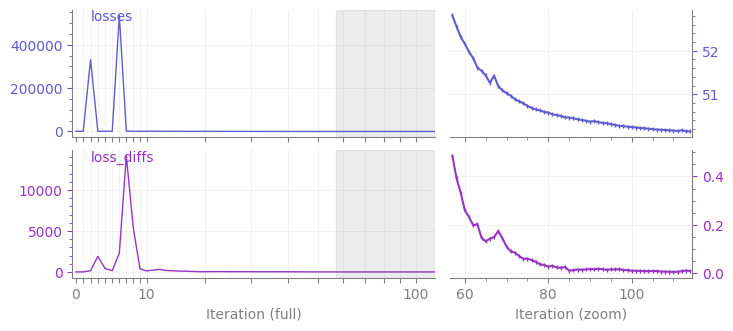

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [131]:
optmzr.plot()

# Conclusion
It works! Just need to test hyperparameters more now.

Seems a lot slower than my code though...